# Noise Analysis of HP-West

### Importing necessary libraries

In [1]:
%pylab inline
import time
import datetime
import glob
import os
import platform
import scipy.ndimage as snd
import numpy as np
from matplotlib.pyplot import *

Populating the interactive namespace from numpy and matplotlib


### Creating necessary functions 

In [37]:
#Checks if the value is a number
def is_number(a):
    try:
        float(a)
        return True
    except ValueError: 
        return False

#Returns the full path of the file (Takes into account differences in slash conventions)
def full_path(file_name):
    system = platform.system().upper()
    if system == 'DARWIN' or system == 'LINUX' or system == 'LINUX2':
        return os.path.dirname(os.path.realpath(file_name))+ '/' + file_name
    elif system == 'WIN32' or system =='WINDOWS':
        return os.path.dirname(os.path.realpath(file_name))+ '\\' + file_name
        
        
#This retrieves the relevant binding and count data from the HP-West .XPS output
def get_bindings_cts(file_name):
    file_contents = open(full_path(file_name), "r")
    binding, counts = [], []
    data_points = 0
    
    for line in file_contents:
        raw_data = line.split()
        if (raw_data and is_number(raw_data[0])):
            data_points += 1
            binding.append(float(raw_data[0]))
            counts.append(float(raw_data[1]))
            
    file_contents.close()
    print "Extracting " + str(data_points) + " data point(s) from file."
    return binding, counts

#Extracts and concactinates all data specified
def extract_data(file_paths):
    binding, counts = [], []
    number_of_files = 0
    paths = open(full_path(file_paths), "r")
    
    for line in paths:
        number_of_files += 1
        new_binding, new_counts = get_bindings_cts(line.split()[0])
        for i in range(len(new_binding)):
            binding.append(new_binding[i])
            counts.append(new_counts[i])
    
    paths.close()
    print "\nParsed through " + str(number_of_files) + " files."
    print "Total of : " + str(len(binding)) + " data point(s)."
    return binding, counts

#Caution!!! Can be slow if there are a lot of data points
#Plots, saves, and labels data (alpha = transparency, option parameter/ save = optional parameter to save file with timestamp)
def plot_data(x, y, alpha_value = .01, save = False):
    figure = (figsize(10,10))
    plot(x, y, 'o', alpha = alpha_value)
    title("HP WEST: Binding Energy vs Frequency")
    xlabel("Binding Energy (eV)")
    ylabel("Frequency (Counts)")
    if save:
        timestamp = time.time()
        st = datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d__%HH%MM-%SS')
        fullname = "Plot_From_" + st + ".png"
        savefig(fullname)
    
#Allows for inspection of a specific range
def inspection(x, y, minimum, maximum):
    binding, counts = [], []
    for i in range(len(x)):
        if x[i] > minimum and x[i] < maximum:
            binding.append(x[i])
            counts.append(y[i])
    return binding, counts    

#Linear regression to remove slope
def simple_linear_regression(input_feature, output):
    sum_inp = sum(input_feature)
    sum_out = sum(output)
    product, squared_inp = [], []
    for i in range(len(input_feature)): 
        product.append(input_feature[i]*output[i])
    sum_product = sum(product)
    for i in range(len(input_feature)): 
        squared_inp.append(input_feature[i] ** 2)
    sum_squared_inp = sum(squared_inp)
    squared_sum_inp = sum_inp ** 2
    N = len(input_feature)
    slope = ((N * sum_product) - (sum_inp * sum_out))/((N*sum_squared_inp) - squared_sum_inp)
    intercept = (sum_out - (slope * sum_inp))/N
    return (intercept, slope)

#Runs the linear regression and creates predicted y coordinates with with respect to current x coord
def create_regression_line(x, y):
    y2 = []
    intercept, slope = simple_linear_regression(x,y)
    for i in range(len(x)):
        y2.append(intercept + slope * x[i])
    return y2


#Determines difference between predicted and observed
def diff_pre_obs(y, y2):
    err = []
    for i in range(len(y)):
        err.append(y2[i]-y[i])
    return err

# Running Code

In [38]:
bindings, counts = extract_data("file_list.txt")

Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.
Extracting 2560 data point(s) from file.

Parsed through 8 files.
Total of : 20480 data point(s).


In [39]:
x, y = inspection(bindings, counts, 516, 518)
y2 = create_regression_line(x,y)

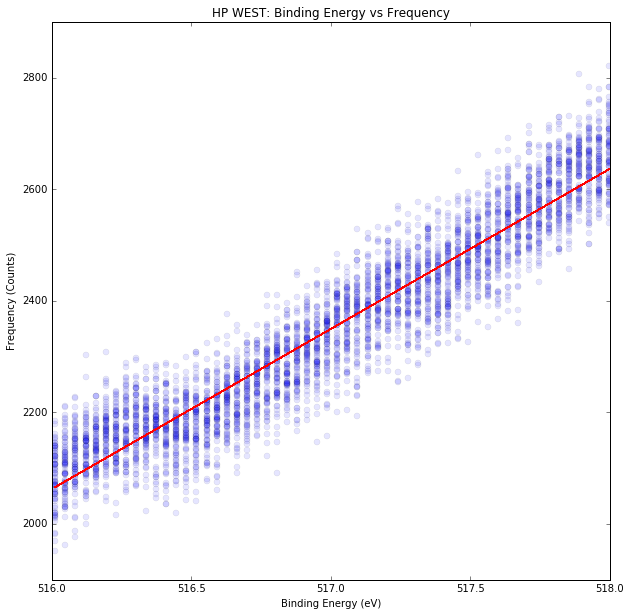

In [43]:
plot_data(x,y,.1)
plot(x,y2, 'r')
timestamp = time.time()
st = datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d__%HH%MM-%SS')
fullname = "Plot_From_" + st + ".png"
savefig(fullname)

(array([    6.,    53.,   251.,   762.,  1154.,  1149.,   706.,   301.,
           83.,    15.]),
 array([-205.47581734, -164.71857307, -123.9613288 ,  -83.20408453,
         -42.44684026,   -1.68959599,   39.06764829,   79.82489256,
         120.58213683,  161.3393811 ,  202.09662537]),
 <a list of 1 Patch objects>)

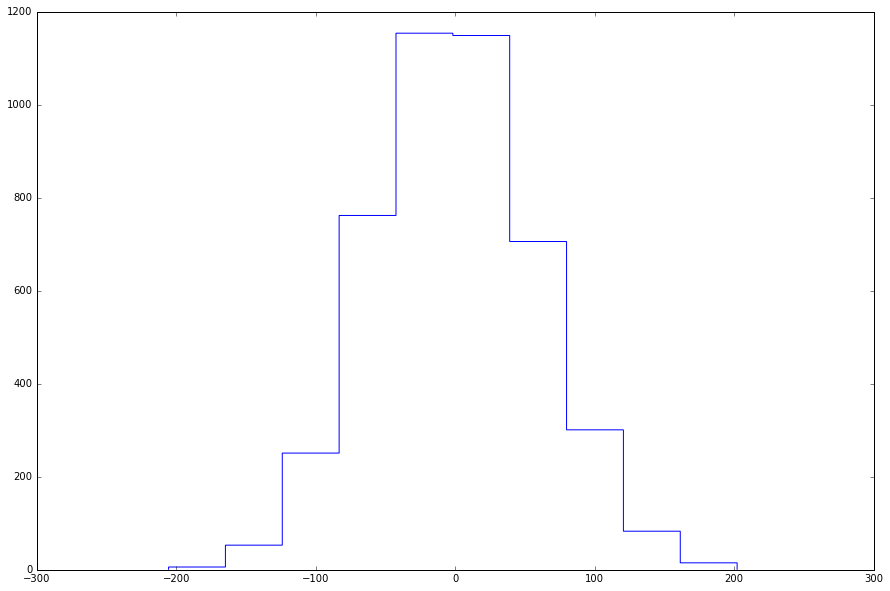

In [49]:
err = diff_pre_obs(y, y2)
figure = (figsize(15,10))
hist(err, histtype='step')

# Shifting values so that you can run analysis on them (otherwise there is an issue with dividing by zero)

In [60]:
shifted = []
for line in err:
    shifted.append(line + 300)

(array([    6.,    53.,   251.,   762.,  1154.,  1149.,   706.,   301.,
           83.,    15.]),
 array([  94.52418266,  135.28142693,  176.0386712 ,  216.79591547,
         257.55315974,  298.31040401,  339.06764829,  379.82489256,
         420.58213683,  461.3393811 ,  502.09662537]),
 <a list of 10 Patch objects>)

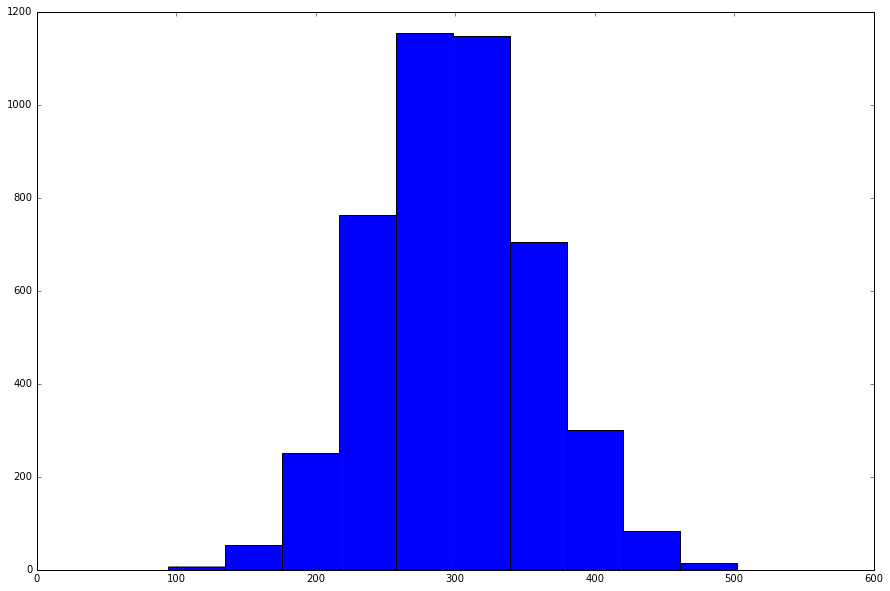

In [61]:
hist(shifted)